# Converting Institution data to AEZs

The processing steps are run on the data as it comes from the institutions, but now we can take that and turn it into AEZ regions to test how well our method does based on regional differences.

start by importing what you need 

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


plan is to read in the institution data as gpd tables, combine them into one big table and then make cuts to that big table based on the shape files of the AEZs

In [2]:
# read in the institution files, preferably the ones that have had columns dropped already in the processing step
AGRYHMET = pd.read_csv('../Results/WOfS_Assessment/wofs_ls/Point_Based/Institutions/AGRYHMET_wofs_ls_valid.csv')
RCMRD = pd.read_csv('../Results/WOfS_Assessment/wofs_lsPoint_Based/Institutions/RCMRD_wofs_ls_valid.csv')
OSS = pd.read_csv('../Results/WOfS_Assessment/wofs_ls/Point_Based/Institutions/OSS_wofs_ls_valid.csv')
AFRIGIST = pd.read_csv('../Results/WOfS_Assessment/wofs_ls/Point_Based/Institutions/AFRIGIST_wofs_ls_valid.csv')

In [3]:
# concatenate the institution data into a big table and check it
institutions = [AGRYHMET, RCMRD, OSS, AFRIGIST]
combined = pd.concat(institutions)
combined

,Unnamed: 0,PLOT_ID,LON,LAT,FLAGGED,ANALYSES,MONTH,WATERFLAG,geometry,CLASS_WET,CLEAR_OBS
0,0,137711631.0,17.782114,7.802986,0.0,1.0,8,0,POINT (1715730.000122329 992460.0000373685),0.0,0.0
1,1,137711631.0,17.782114,7.802986,0.0,1.0,10,0,POINT (1715730.000122329 992460.0000373685),1.0,2.0
2,2,137711631.0,17.782114,7.802986,0.0,1.0,1,1,POINT (1715730.000122329 992460.0000373685),NaN,NaN
3,3,137711631.0,17.782114,7.802986,0.0,1.0,2,1,POINT (1715730.000122329 992460.0000373685),1.0,2.0
4,4,137711631.0,17.782114,7.802986,0.0,1.0,3,1,POINT (1715730.000122329 992460.0000373685),0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
13830,13830,137482804.0,13.838962,-9.369115,0.0,1.0,11,0,POINT (1335269.999683705 -1190069.999960346),0.0,0.0
13831,13831,137482804.0,13.838962,-9.369115,0.0,1.0,11,2,POINT (1335269.999683705 -1190069.999960346),0.0,0.0
13832,13832,137482804.0,13.838962,-9.369115,0.0,1.0,12,0,POINT (1335269.999683705 -1190069.999960346),0.0,0.0
13833,13833,137482804.0,13.838962,-9.369115,0.0,1.0,12,2,POINT (1335269.999683705 -1190069.999960346),0.0,0.0


In [4]:
# save the combined table as a csv
combined.to_csv('../Results/WOfS_Assessment/wofs_ls/Point_Based/Africa_Combined_wofs_ls_valid.csv')

Now that they are all combined into one table, we need to turn it into geopandas to be able to compare it with the shape files...

In [5]:
# make a geopandas object
geo_combined = gpd.GeoDataFrame(combined, geometry=gpd.points_from_xy(combined.LON, combined.LAT), crs='EPSG:4326')
geo_combined = geo_combined.to_crs('EPSG:6933')
# save as a shape file for later
geo_combined.to_file('../Results/WOfS_Assessment/wofs_ls/Point_Based/Africa_Combined_wofs_ls_valid.shp')
#check the crs
geo_combined.crs

<Projected CRS: EPSG:6933>
Name: WGS 84 / NSIDC EASE-Grid 2.0 Global
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 86°S to 86°N
- bounds: (-180.0, -86.0, 180.0, 86.0)
Coordinate Operation:
- name: US NSIDC EASE-Grid 2.0 Global
- method: Lambert Cylindrical Equal Area
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
# read in the shape file, and set the co-ordinates
combined_shp = gpd.read_file('../Results/WOfS_Assessment/Point_Based/wofs_ls/Africa_Combined_wofs_ls_valid.shp')
combined_shp.crs

<Projected CRS: EPSG:6933>
Name: WGS 84 / NSIDC EASE-Grid 2.0 Global
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 86°S to 86°N
- bounds: (-180.0, -86.0, 180.0, 86.0)
Coordinate Operation:
- name: US NSIDC EASE-Grid 2.0 Global
- method: Lambert Cylindrical Equal Area
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now that it's a geopandas object we should be able to use a shape file to clip it?

In [7]:
shp_east = gpd.read_file('../Data/AEZs/Eastern.shp')
shp_east.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
#check that the coordinates match and set them to be the same
shp_east = shp_east.to_crs('EPSG:6933')
shp_east.plot()
geo_combined.plot()

<AxesSubplot:>

In [9]:
#east_wofs = gpd.sjoin(combined_shp.to_crs(shp_east.crs), shp_east, op='within')
east_wofs = gpd.sjoin(geo_combined, shp_east, op='within')

<AxesSubplot:>

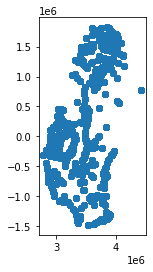

In [10]:
# check that the shape looks right
east_wofs.plot()

In [11]:
#check the table
east_wofs

,Unnamed: 0,PLOT_ID,LON,LAT,FLAGGED,ANALYSES,MONTH,WATERFLAG,geometry,CLASS_WET,CLEAR_OBS,index_right,ID,CODE,COUNTRY
681,681,137387091.0,36.479901,9.014053,0.0,1.0,1,1,POINT (3519810.000 1145340.000),1.0,1.0,0,None,None,Eastern
682,682,137387091.0,36.479901,9.014053,0.0,1.0,2,1,POINT (3519810.000 1145340.000),1.0,1.0,0,None,None,Eastern
683,683,137387091.0,36.479901,9.014053,0.0,1.0,3,1,POINT (3519810.000 1145340.000),0.0,0.0,0,None,None,Eastern
684,684,137387091.0,36.479901,9.014053,0.0,1.0,4,1,POINT (3519810.000 1145340.000),0.0,0.0,0,None,None,Eastern
685,685,137387091.0,36.479901,9.014053,0.0,1.0,5,1,POINT (3519810.000 1145340.000),0.0,0.0,0,None,None,Eastern
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7003,7003,137755421.0,40.910583,10.325362,0.0,1.0,5,2,POINT (3947310.000 1310310.000),1.0,1.0,0,None,None,Eastern
7004,7004,137755421.0,40.910583,10.325362,0.0,1.0,11,2,POINT (3947310.000 1310310.000),1.0,1.0,0,None,None,Eastern
7005,7005,137755421.0,40.910583,10.325362,0.0,1.0,12,2,POINT (3947310.000 1310310.000),1.0,2.0,0,None,None,Eastern
7006,7006,137755421.0,40.910583,10.325362,0.0,1.0,7,3,POINT (3947310.000 1310310.000),0.0,1.0,0,None,None,Eastern


In [12]:
# save out to file for the accuracy assesments
east_wofs.to_csv('../Results/WOfS_Assessment/wofs_ls/Point_Based/Eastern_wofs_ls_valid.csv')

In [13]:
# and then repeat for the other regions
shp_north = gpd.read_file('../Data/AEZs/Northern.shp')
shp_north = shp_north.to_crs('EPSG:6933')
north_wofs = gpd.sjoin(geo_combined, shp_north, op='within')

<AxesSubplot:>

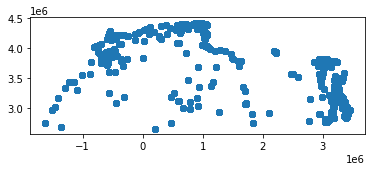

In [14]:
# check that the shape looks right
north_wofs.plot()

In [15]:
#check the table
north_wofs

,Unnamed: 0,PLOT_ID,LON,LAT,FLAGGED,ANALYSES,MONTH,WATERFLAG,geometry,CLASS_WET,CLEAR_OBS,index_right,ID,CODE,COUNTRY
2893,2893,137755561.0,-8.847683,30.996639,0.0,1.0,1,0,POINT (-853680.000 3768720.000),0.0,0.0,0,546,-,Northern
2894,2894,137755561.0,-8.847683,30.996639,0.0,1.0,2,0,POINT (-853680.000 3768720.000),0.0,0.0,0,546,-,Northern
2895,2895,137755561.0,-8.847683,30.996639,0.0,1.0,4,0,POINT (-853680.000 3768720.000),0.0,0.0,0,546,-,Northern
2896,2896,137755561.0,-8.847683,30.996639,0.0,1.0,5,0,POINT (-853680.000 3768720.000),0.0,0.0,0,546,-,Northern
2897,2897,137755561.0,-8.847683,30.996639,0.0,1.0,6,0,POINT (-853680.000 3768720.000),0.0,0.0,0,546,-,Northern
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8668,8668,137755560.0,32.430103,31.028901,0.0,1.0,8,2,POINT (3129060.000 3772260.000),1.0,2.0,0,546,-,Northern
8669,8669,137755560.0,32.430103,31.028901,0.0,1.0,9,2,POINT (3129060.000 3772260.000),0.0,0.0,0,546,-,Northern
8670,8670,137755560.0,32.430103,31.028901,0.0,1.0,10,2,POINT (3129060.000 3772260.000),0.0,0.0,0,546,-,Northern
8671,8671,137755560.0,32.430103,31.028901,0.0,1.0,11,2,POINT (3129060.000 3772260.000),0.0,0.0,0,546,-,Northern


In [16]:
# save out to file for the accuracy assesments
north_wofs.to_csv('../Results/WOfS_Assessment/wofs_ls/Point_Based/Northern_wofs_ls_valid.csv')

In [17]:
# and then repeat for the other regions
shp_south = gpd.read_file('../Data/AEZs/Southern.shp')
shp_south = shp_south.to_crs('EPSG:6933')
south_wofs = gpd.sjoin(geo_combined, shp_south, op='within')
# save out to file for the accuracy assesments
south_wofs.to_csv('../Results/WOfS_Assessment/wofs_ls/Point_Based/Southern_wofs_ls_valid.csv')

In [18]:
# and then repeat for the other regions
shp_sahel = gpd.read_file('../Data/AEZs/Sahel.shp')
shp_sahel = shp_sahel.to_crs('EPSG:6933')
sahel_wofs = gpd.sjoin(geo_combined, shp_sahel, op='within')
# save out to file for the accuracy assesments
sahel_wofs.to_csv('../Results/WOfS_Assessment/wofs_ls/Point_Based/Sahel_wofs_ls_valid.csv')

In [19]:
# and then repeat for the other regions
shp_west = gpd.read_file('../Data/AEZs/Western.shp')
shp_west = shp_west.to_crs('EPSG:6933')
west_wofs = gpd.sjoin(geo_combined, shp_west, op='within')
# save out to file for the accuracy assesments
west_wofs.to_csv('../Results/WOfS_Assessment/wofs_ls/Point_Based/Western_wofs_ls_valid.csv')

In [20]:
# and then repeat for the other regions
shp_central = gpd.read_file('../Data/AEZs/Central.shp')
shp_central = shp_central.to_crs('EPSG:6933')
central_wofs = gpd.sjoin(geo_combined, shp_central, op='within')
# save out to file for the accuracy assesments
central_wofs.to_csv('../Results/WOfS_Assessment/wofs_ls/Point_Based/Central_wofs_ls_valid.csv')

In [21]:
# and then repeat for the other regions
shp_io = gpd.read_file('../Data/AEZs/Indian_ocean.shp')
shp_io = shp_io.to_crs('EPSG:6933')
io_wofs = gpd.sjoin(geo_combined, shp_io, op='within')
# save out to file for the accuracy assesments
io_wofs.to_csv('../Results/WOfS_Assessment/wofs_ls/Point_Based/Indian_ocean_wofs_ls_valid.csv')

<AxesSubplot:>

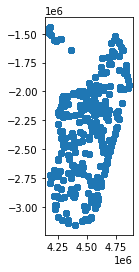

In [22]:
io_wofs.plot()